In [3]:
import pandas as pd
import numpy as np
import datetime as dt
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

In [4]:
# Load transaction data
df = pd.read_csv("transactions.csv")

In [5]:
# Convert transaction_date to datetime
df["transaction_date"] = pd.to_datetime(df["transaction_date"])

In [6]:
# Calculate Recency, Frequency, and Monetary Value
snapshot_date = df["transaction_date"].max() + dt.timedelta(days=1)
df_rfm = df.groupby("user_id").agg({
    "transaction_date": lambda x: (snapshot_date - x.max()).days,
    "transaction_id": "count",
    "amount": "sum"
}).reset_index()

In [7]:
# Rename columns
df_rfm.rename(columns={
    "transaction_date": "Recency",
    "transaction_id": "Frequency",
    "amount": "MonetaryValue"
}, inplace=True)

In [8]:
print("RFM Dataframe:")
print(df_rfm.head())
print("\n")

RFM Dataframe:
   user_id  Recency  Frequency  MonetaryValue
0     1001        9          2        1250.50
1     1002       42          1        1000.00
2     1003        6          2         551.00
3     1004        1          3        5250.50
4     1005       22          2        1750.25




In [10]:
# Load AUM data
df_aum = pd.read_csv("aum.csv")

In [11]:
# Convert start_date to datetime
df_aum["start_date"] = pd.to_datetime(df_aum["start_date"])

In [12]:

# Calculate the number of days since the customer started investing
df_aum["InvestmentDays"] = (snapshot_date - df_aum["start_date"]).dt.days

In [13]:
# Calculate AUM per day
df_aum["AUMperDay"] = df_aum["aum"] / df_aum["InvestmentDays"]

In [14]:
# Merge RFM and AUM dataframes
df_hybrid = pd.merge(df_rfm, df_aum[["user_id", "AUMperDay"]], on="user_id", how="inner")

In [15]:

print("Hybrid RFM-AUM Dataframe:")
print(df_hybrid.head())
print("\n")

Hybrid RFM-AUM Dataframe:
   user_id  Recency  Frequency  MonetaryValue   AUMperDay
0     1001        9          2        1250.50   80.690250
1     1002       42          1        1000.00  188.005714
2     1003        6          2         551.00   84.272688
3     1004        1          3        5250.50  352.147113
4     1005       22          2        1750.25  385.041111




In [16]:
# Standardize RFM and AUM values
scaler = StandardScaler()
rfm_aum_scaled = scaler.fit_transform(df_hybrid[['Recency', 'Frequency', 'MonetaryValue', 'AUMperDay']])

In [17]:
# Convert to a dataframe
rfm_aum_scaled_df = pd.DataFrame(rfm_aum_scaled, columns=['R_score', 'F_score', 'M_score', 'AUM_score'])

In [18]:

# Invert R_score so that higher values indicate more recent activity
rfm_aum_scaled_df['R_score'] = -rfm_aum_scaled_df['R_score']

In [19]:
# Add user_id back to the dataframe
rfm_aum_scaled_df['user_id'] = df_hybrid['user_id']

In [20]:
print("Standardized RFM-AUM Scores:")
print(rfm_aum_scaled_df.head())
print("\n")

Standardized RFM-AUM Scores:
    R_score   F_score   M_score  AUM_score  user_id
0  0.394611  0.000000 -0.610172  -1.267811     1001
1 -2.318339 -1.581139 -0.717434  -0.410276     1002
2  0.641243  0.000000 -0.909691  -1.239185     1003
3  1.052296  1.581139  1.102591   0.901343     1004
4 -0.674127  0.000000 -0.396183   1.164192     1005




In [21]:
# Prepare data for clustering
X = rfm_aum_scaled_df[['R_score', 'F_score', 'M_score', 'AUM_score']]

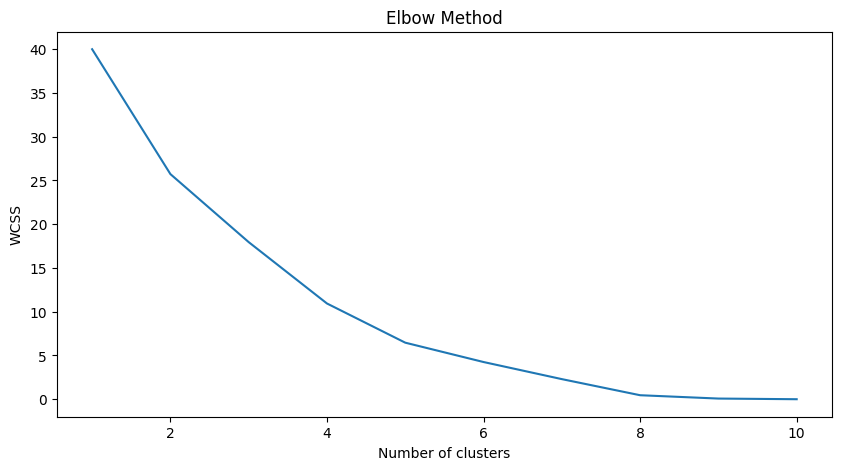

In [22]:
# Determine optimal number of clusters using elbow method
wcss = []
for i in range(1, 11):
    kmeans = KMeans(n_clusters=i, init='k-means++', max_iter=300, n_init=10, random_state=0)
    kmeans.fit(X)
    wcss.append(kmeans.inertia_)

plt.figure(figsize=(10,5))
plt.plot(range(1, 11), wcss)
plt.title('Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.show()

In [23]:
# Fit K-means clustering to data (assuming 4 clusters from elbow method)
kmeans = KMeans(n_clusters=4, init='k-means++', max_iter=300, n_init=10, random_state=0)
cluster_labels = kmeans.fit_predict(X)

In [24]:
# Add cluster labels to the dataframe
rfm_aum_scaled_df['Cluster'] = cluster_labels

print("Final Dataframe with Cluster Labels:")
print(rfm_aum_scaled_df.head())
print("\n")

Final Dataframe with Cluster Labels:
    R_score   F_score   M_score  AUM_score  user_id  Cluster
0  0.394611  0.000000 -0.610172  -1.267811     1001        0
1 -2.318339 -1.581139 -0.717434  -0.410276     1002        2
2  0.641243  0.000000 -0.909691  -1.239185     1003        0
3  1.052296  1.581139  1.102591   0.901343     1004        3
4 -0.674127  0.000000 -0.396183   1.164192     1005        0




In [25]:
# Basic cluster analysis
cluster_analysis = rfm_aum_scaled_df.groupby('Cluster').mean()
print("Cluster Analysis:")
print(cluster_analysis)

Cluster Analysis:
          R_score   F_score   M_score  AUM_score      user_id
Cluster                                                      
0        0.367207 -0.263523 -0.610172  -0.079572  1005.333333
1       -1.085180  1.581139  1.638151  -1.465819  1007.000000
2       -2.318339 -1.581139 -0.717434  -0.410276  1002.000000
3        0.600137  0.790569  1.370157   1.176763  1007.000000


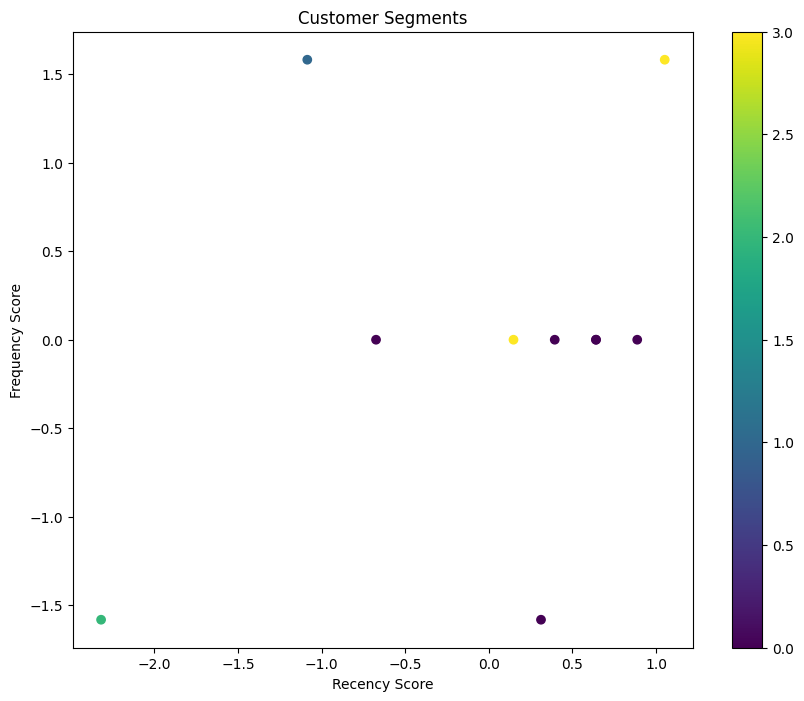

In [26]:
# Visualize clusters (example with 2 dimensions)
plt.figure(figsize=(10,8))
scatter = plt.scatter(X['R_score'], X['F_score'], c=cluster_labels, cmap='viridis')
plt.title('Customer Segments')
plt.xlabel('Recency Score')
plt.ylabel('Frequency Score')
plt.colorbar(scatter)
plt.show()